In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import scipy.special
import scipy.optimize
import itertools
import imp

import cvpinns
imp.reload(cvpinns)

tf.keras.backend.set_floatx("float64")

In [2]:
#analytical solution, 1 rarefaction, 3 shock
def sod(xt,Ul,Ur,gamma=1.4):
    rhol,jl,El = Ul
    rhor,jr,Er = Ur
    
    ul = jl/rhol
    ur = jr/rhor
    pl = (gamma-1.)*(El-.5*rhol*ul**2)
    pr = (gamma-1.)*(Er-.5*rhor*ur**2)
    
    cl = np.sqrt(gamma*pl/rhol)
    cr = np.sqrt(gamma*pr/rhor)

    def phil(p):
        if p<=pl:
            u = ul + 2*cl/(gamma-1) * (1.-(p/pl)**((gamma-1)/(2*gamma)))
        else:
            u = ul + (2*cl/np.sqrt(2*gamma*(gamma-1)) 
                      * (1.-p/pl)/np.sqrt(1+p/pl * (gamma+1)/(gamma-1)))
        return u

    def phir(p):
        if p<=pr:
            u = ur - 2*cr/(gamma-1) * (1.-(p/pr)**((gamma-1)/(2*gamma)))
        else:
            u = ur - (2*cr/np.sqrt(2*gamma*(gamma-1))
                      * (1.-p/pr)/np.sqrt(1+p/pr * (gamma+1)/(gamma-1)))
        return u

    def phi(p):
        return phir(p) - phil(p)

    ps = scipy.optimize.root_scalar(phi,x0=pr,x1=pl).root
    us = phil(ps)
    rhosr = ((1 + (gamma+1)/(gamma-1) * ps/pr)
                     / (ps/pr + (gamma+1)/(gamma-1)) * rhor)
    rhosl = (ps/pl)**(1./gamma)*rhol
    
    s = (rhosr * us - rhor*ur)/(rhosr - rhor)

    csl = np.sqrt(gamma*ps/rhosl)
    laml = ul - cl
    lamsl = us - csl
    xtr = np.reshape(xt,(np.prod(xt.shape[0:-1]),2))

    u = np.zeros((xtr.shape[0],3))
    
    for i,xti in enumerate(xtr):
        if xti[0]<1e-12:
            if xti[1]<0:
                rho = rhol
                v = ul
                p = pl
            else:
                rho = rhor
                v = ur
                p = pr
        else:                
            xi = xti[1]/xti[0]
            if xi <= laml:
                rho = rhol
                v = ul
                p = pl
            elif xi > laml and xi <= lamsl:
                v = ((gamma-1)*ul + 2*(cl+xi))/(gamma+1)
                rho = (rhol**gamma*(v-xi)**2/(gamma*pl))**(1./(gamma-1))
                p = (pl/rhol**gamma)*rho**gamma
            elif xi > lamsl and xi <= us:
                rho = rhosl
                v = us
                p = ps
            elif xi > us and xi <= s:
                rho = rhosr
                v = us
                p = ps
            else:
                rho = rhor
                v = ur
                p = pr
        
        u[i,0] = rho
        u[i,1] = rho*v
        u[i,2] = p/(gamma-1) + .5*rho*v**2
    return np.reshape(u,xt.shape[0:-1]+(3,))

In [3]:
#domain
L = [[0,1],[-2.5,2.5]]

#grid size
nx =[128,128]


#left and right states
Ul = [3.,0,3./.4]
Ur = [1.,0.,1./.4]

#compute analytical solution
x_data = np.transpose(np.mgrid[L[0][0]:L[0][1]:nx[0]*1j,
                            L[1][0]:L[1][1]:nx[1]*1j],(1,2,0))
u_data = sod(x_data,Ul,Ur)

In [4]:
#quadrature specification. 3 segment composite trapezoid
pts=4
xi = np.linspace(-1,1,pts)
wi = np.array([1.] + [2. for _ in range(pts-2)] + [1.])
wi = 2.*wi/sum(wi)


quad = {'0':(xi,wi),'1':(xi,wi)}

In [5]:
#neural network for solution, x->u
width = 64
depth = 8
dimi = 2
dimo = 3
act = tf.nn.relu
u = tf.keras.Sequential(
                 [tf.keras.layers.Dense(width,activation=act,
                                input_shape=(None,dimi),dtype=tf.float64)]
                +[tf.keras.layers.Dense(width,activation=act,
                                dtype=tf.float64) for _ in range(depth-1)]
                +[tf.keras.layers.Dense(dimo,dtype=tf.float64,use_bias=False)]
               )

#neural network for EOS, (rho,e)->s
width = 4
depth = 4
dimi = 2
dimo = 1
act = tf.nn.tanh
EOS2 = tf.keras.Sequential(
                 [tf.keras.layers.Dense(width,activation=act,
                                input_shape=(None,dimi),dtype=tf.float64)]
                +[tf.keras.layers.Dense(width,activation=act,
                                dtype=tf.float64) for _ in range(depth-1)]
                +[tf.keras.layers.Dense(dimo,dtype=tf.float64,use_bias=False)]
               )
EOS = lambda u: EOS2(u) + tf.expand_dims(u[...,1],-1)
EOS.variables = EOS2.variables

# gamma =1.4
# def EOS(uxt):e
#     return tf.math.log(tf.math.divide_no_nan(tf.nn.relu(uxt[...,1])**(1./(gamma-1)),tf.nn.relu(uxt[...,0])+1e-10)+1e-10)

In [6]:
#extracts (rho,e) from u
@tf.function
def getrhoe(uxi):
    return tf.stack([uxi[...,0],tf.math.divide_no_nan(uxi[...,2],uxi[...,0])
                     - 0.5*tf.math.divide_no_nan(uxi[...,1],uxi[...,0])**2],-1)

#computes pressure via EOS
@tf.function
def getp(rhoe):
    with tf.GradientTape() as g:
        g.watch(rhoe)
        s = EOS(rhoe)
        ss = tf.reduce_sum(s)

    J = g.gradient(ss,rhoe)
    p = -rhoe[...,0]**2*tf.math.divide_no_nan(J[...,0],J[...,1])
    return p

In [7]:
#PDE for euler equations

#initial condition
@tf.function
def IC(x):
    return tf.expand_dims(tf.cast(x[...,1]< 0,tf.float64),-1)*Ul \
          +tf.expand_dims(tf.cast(x[...,1]>=0,tf.float64),-1)*Ur

#left boundary condition
@tf.function
def BCl(x):
    return tf.ones(x.shape[0:-1]+[1],tf.float64)*Ul

#right boundary condition
@tf.function
def BCr(x):
    return tf.ones(x.shape[0:-1]+[1],tf.float64)*Ur

#flux in x direction
@tf.function
def F1(ux):
    p = getp(getrhoe(ux))
    return tf.stack([
                ux[...,1],
                tf.math.divide_no_nan(ux[...,1]**2,ux[...,0]) + p,
                (ux[...,2] + p) * tf.math.divide_no_nan(ux[...,1],ux[...,0])
                ],-1)

#flux in t direction
F0 = lambda ux:ux

euler = cvpinns.PDE(L,nx,quad,F0,F1,IC,BCl,BCr,u)

In [8]:
#PDIE for entropy inequality

@tf.function
def Q0(ux):
    s = EOS(getrhoe(ux))
    return -tf.expand_dims(ux[...,0],-1)*s

@tf.function
def Q1(ux):
    s = EOS(getrhoe(ux))
    return -tf.expand_dims(ux[...,1],-1)*s


euler_ent = cvpinns.PDE(L,nx,quad,Q0,Q1,IC,BCl,BCr,u)

In [9]:
#total variation dimishing penalty
@tf.function
def getTVDp():
    ux = euler.u(euler.x)
    TV = tf.reduce_sum(euler.dx[1]*tf.abs(ux[:,1::]-ux[:,0:-1]),1)
    TVDp = tf.reduce_sum(euler.dx[0]*tf.nn.relu(TV[1::]-TV[0:-1])**2)
    return TVDp

In [10]:
#thermodynamics penalty
rhoe_thermp = tf.transpose(np.mgrid[0.5:3.5:100j,1.5:3.5:100j],(1,2,0))
@tf.function
def getThermop():
    with tf.GradientTape(persistent=True) as g2:
        g2.watch(rhoe_thermp)
        with tf.GradientTape() as g:
            g.watch(rhoe_thermp)
            sS = tf.reduce_sum(EOS(rhoe_thermp))
        ds = g.gradient(sS,rhoe_thermp)
        dsdrho = ds[...,0]
        dsde = ds[...,1]
        dsdeS = tf.reduce_sum(dsde)
        rho2dsdrhos = tf.reduce_sum(rhoe_thermp[...,0]**2*dsdrho)
    d2sd2e = g2.gradient(dsdeS,rhoe_thermp)[...,1]
    drho2dsdrhos = g2.gradient(rho2dsdrhos,rhoe_thermp)[...,0]
    return tf.reduce_mean(tf.nn.relu(drho2dsdrhos)**2
                          + tf.nn.relu(d2sd2e)**2 + tf.nn.relu(-dsde)**2)

In [11]:
#combines loss terms
@tf.function
def getLoss():
    return (
                tf.reduce_sum(euler.getRES()**2)
              + tf.reduce_sum(tf.nn.relu(euler_ent.getRES())**2)
              + getTVDp()
              + tf.reduce_mean((u(x_data)-u_data)**2)/10
              + 1000*getThermop()
            )

In [12]:
#fit EOS to data
def train(lr,iters):
    #Optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    #optimize loss over u and EOS
    varlist = u.variables + EOS.variables

    #training function
    @tf.function
    def GD():
        with tf.GradientTape() as g:
            loss = getLoss()
        G = g.gradient(loss,varlist)
        opt.apply_gradients(zip(G,varlist))
        
    for i in range(iters):
        GD()
        if not(i%100):
            print('iter:',i,'Loss:',getLoss().numpy())        

In [ ]:
print('stage 1')
train(1e-2,2000)
print('\nstage 2')
train(1e-3,20000)
print('\nstage 3')
train(1e-4,20000)

In [ ]:
#solve euler equations with learned EOS via finite difference

xfd = np.transpose(np.mgrid[0:0:1j,L[1][0]:L[1][1]:4000j],(1,2,0))
dx_fd = xfd[:,1,1]-xfd[:,0,1]
dt_fd = dx_fd/4
def getFD():
    ufd = IC(xfd)[0]
    nu=1e-3
    D = np.zeros((3,4000))
    D[0]=-dt_fd*nu/dx_fd**2
    D[1]=1+2*dt_fd*nu/dx_fd**2
    D[2]=-dt_fd*nu/dx_fd**2

    D[0,0:2]=0
    D[1,0] = 1
    D[1,-1] = 1
    D[2,-2::]=0
    Dj = np.copy(D)
    Dj[0,1] = 0
    def upd(ufd):        
        ustar = np.zeros(ufd.shape)
        unew = np.zeros(ufd.shape)
        
        F = F1(ufd)
        
        ustar[1:-1] = ufd[1:-1] - dt_fd/(2*dx_fd) * (F[2::]-F[0:-2]) 
        ustar[0] = Ul
        ustar[-1] = Ur

        unew[...,0] = scipy.linalg.solve_banded((1, 1), D, ustar[...,0])
        unew[...,1] = scipy.linalg.solve_banded((1, 1), D, ustar[...,1])
        unew[...,2] = scipy.linalg.solve_banded((1, 1), D, ustar[...,2])

        return unew

    
    for i in range(int(L[0][1]/dt_fd)):
        ufd = upd(ufd)

    return ufd
ufd = getFD()

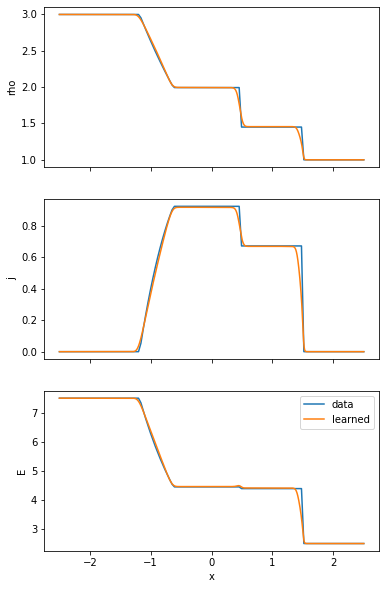

In [15]:
#compare solution from learned EOS to data

fig,ax = plt.subplots(3,figsize=(6,10),sharex=True)
ax[0].plot(x_data[-1,:,1],u_data[-1,:,0])
ax[0].plot(xfd[0,:,1],ufd[:,0])
ax[1].plot(x_data[-1,:,1],u_data[-1,:,1])
ax[1].plot(xfd[0,:,1],ufd[:,1])
ax[2].plot(x_data[-1,:,1],u_data[-1,:,2],label='data')
ax[2].plot(xfd[0,:,1],ufd[:,2],label='learned')
ax[2].set_xlabel('x')
ax[0].set_ylabel('rho')
ax[1].set_ylabel('j')
ax[2].set_ylabel('E')
ax[2].legend()